**라이브러리 불러오기**

In [60]:
import os

# 데이터 처리
import pandas as pd
import numpy as np

# 시각화
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns

# 분석
import statsmodels.api as sm
import scipy

# 그래프 글꼴 설정
plt.rc('axes', unicode_minus=False)
plt.rc('font', family='NanumBarunGothic')

In [2]:
print(sns.__version__)
print(pd.__version__)

0.11.1
1.2.0


### 1. 데이터 접근하기 - 데이터 기본 파악

 차량 수요 예측 모델링을 위해 서전 가동률 데이터, 존 클리수 데이터, 날씨 데이터를 불러온다.
 
 
사전 가동률이란 당일(D-day) 전에 미리 예약이 발생하여 가동률이 잡힌 것을 의미한다.
내일 이용할 것을 당일이 아닌 오늘, 혹은 그 전에 미리 예약하는 유저들도 있다. 예를 들면 2021년 9월 3일 금용일 현재, 2021년 9월 4일 토요일을 이용 시작일로 하는 카셰어링 예약이 있을 때, D-1일 사전가동률이 잡히게 된다. 존 클릭 수는 특정 존(쏘카가 비치된 주차장)을 클릭한 수이다.

In [3]:
file_path_pre = os.getenv('HOME') + '/aiffel/demand_forecasting/data/pre_operation.csv'
file_path_click = os.getenv('HOME') + '/aiffel/demand_forecasting/data/click_data.csv'
file_path_weather = os.getenv('HOME') + '/aiffel/demand_forecasting/data/weather.csv'

df_pre = pd.read_csv(file_path_pre)
df_click = pd.read_csv(file_path_click)
df_weather = pd.read_csv(file_path_weather)

In [4]:
df_pre.head()

,target_dates,op_rate_0d_all_cars,op_rate_1d_all_cars,op_rate_2d_all_cars,op_rate_3d_all_cars,op_rate_4d_all_cars,op_rate_5d_all_cars,op_rate_6d_all_cars,op_rate_7d_all_cars,op_rate_0d_major_cars,op_rate_1d_major_cars,op_rate_2d_major_cars,op_rate_3d_major_cars,op_rate_4d_major_cars,op_rate_5d_major_cars,op_rate_6d_major_cars,op_rate_7d_major_cars
0,2019-11-20,0.316167,0.128829,0.073450,0.047983,0.041501,0.035837,0.028633,0.023602,0.354157,0.133284,0.078416,0.051335,0.043031,0.037124,0.030191,0.024724
1,2019-04-07,0.433710,0.165792,0.114138,0.091261,0.073171,0.060375,0.048367,0.040212,0.477168,0.162459,0.116169,0.092505,0.075456,0.062375,0.051132,0.040773
2,2020-09-20,0.470135,0.252650,0.181241,0.142521,0.117679,0.095518,0.076442,0.059885,0.469391,0.259594,0.186417,0.146953,0.120212,0.098140,0.078305,0.060749
3,2019-11-28,0.320862,0.132336,0.075752,0.052990,0.038522,0.033602,0.029606,0.025020,0.358306,0.140434,0.082168,0.057721,0.041842,0.036485,0.030878,0.027118
4,2021-06-26,0.444924,0.233424,0.174414,0.144886,0.123617,0.102621,0.086654,0.077878,0.426241,0.230812,0.167328,0.136924,0.114490,0.092528,0.078320,0.070913


- target_dates: 고객이 쏘카 APP에 접속하여 start_date로 삼은 날짜
- op_rate_0d_all_cars: target_date 모든 차량의 d-day 가동률. 가단히 '최종 가동률'이라고 정의함.
- op_rate_1d_all_cars: target_date 모든 차량의 d-1일 전 사전 가동률
- op_rate_0d_major_cars: target_date 주력 차량의 d-day가동률(경형,준중형,소형SUV)
- op_rate_1d_major_cars: target_date 주력 차량의 d-1일 전 사전 가동률(경형,준중형,소형SUV)

In [5]:
df_click.head(15)

,target_dates,click_d_day,click_d_1,click_d_2,click_d_3,click_d_4,click_d_5,click_d_6,click_d_7
0,2019-01-23,0,0,0,0,0,0,0,0
1,2019-07-24,0,0,0,0,0,0,0,0
2,2019-08-21,0,0,0,0,0,0,0,0
3,2019-08-24,0,0,0,0,0,0,0,0
4,2019-08-25,0,0,0,0,0,0,0,0
5,2019-08-26,0,0,0,0,0,0,0,0
6,2019-08-29,0,0,0,0,0,0,0,0
7,2019-08-31,33,0,0,0,0,0,0,0
8,2019-09-01,265846,0,0,0,0,0,0,0
9,2019-09-02,218807,6761,0,0,0,0,0,0


- click_d_day: target_date를 start_date로 삼는 D-day 당일의 APP접속량. 간단히 'D-day의 존 클릭 수'라고 정의함.
- click_d_1: target_date를 start_date로 삼는 D-1일의 APP접속량. 간단히 '1일 전 존 클릭 수'라고 정의함.

In [6]:
df_weather.head()

,date,is_clean,avg_precipitation,avg_temperature
0,2018-01-01,1,0.0,0.2
1,2018-01-02,1,0.0,0.2
2,2018-01-03,0,0.4,-1.3
3,2018-01-04,0,0.7,-1.9
4,2018-01-05,0,2.4,-0.3


- is_clean: 강우 여부(강수/강우가 측정되면 0, 측정되지 않으면 1)
- avg_precipitaion: 해당 날짜의 평균 강수량
- avg_temperature: 해당 날짜의 평균 기온

### 2. EDA (1): 데이터 일관성 확인하기

데이터의 consistency를 검증하지 않고, 무턱대고 EDA를 수행한다면 Raw data로부터 의미 있는 저오, 오라른 정보를 도출할 수 없다.

In [7]:
# 결측치 확인
df_pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 939 entries, 0 to 938
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   target_dates           939 non-null    object 
 1   op_rate_0d_all_cars    939 non-null    float64
 2   op_rate_1d_all_cars    939 non-null    float64
 3   op_rate_2d_all_cars    939 non-null    float64
 4   op_rate_3d_all_cars    939 non-null    float64
 5   op_rate_4d_all_cars    939 non-null    float64
 6   op_rate_5d_all_cars    939 non-null    float64
 7   op_rate_6d_all_cars    939 non-null    float64
 8   op_rate_7d_all_cars    939 non-null    float64
 9   op_rate_0d_major_cars  939 non-null    float64
 10  op_rate_1d_major_cars  939 non-null    float64
 11  op_rate_2d_major_cars  939 non-null    float64
 12  op_rate_3d_major_cars  939 non-null    float64
 13  op_rate_4d_major_cars  939 non-null    float64
 14  op_rate_5d_major_cars  939 non-null    float64
 15  op_rat

: 사전 가동률 데이터는 총 17개의 컬럼과 939일간의 데이터가 있고, 데이터 타입은 target_dates를 제외하고는 모두 float64이다.

In [8]:
df_click.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 793 entries, 0 to 792
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   target_dates  793 non-null    object
 1   click_d_day   793 non-null    int64 
 2   click_d_1     793 non-null    int64 
 3   click_d_2     793 non-null    int64 
 4   click_d_3     793 non-null    int64 
 5   click_d_4     793 non-null    int64 
 6   click_d_5     793 non-null    int64 
 7   click_d_6     793 non-null    int64 
 8   click_d_7     793 non-null    int64 
dtypes: int64(8), object(1)
memory usage: 55.9+ KB


: 존 클릭 수 데이터는 총 9의 컬럼과 793일간의 데이터가 있고, 데이터 타입은 target_dates를 제외하고는 모두 int64이다.

In [9]:
df_weather['date'].min(), df_weather['date'].max()

('2018-01-01', '2021-05-22')

In [10]:
df_weather['date'].nunique()

1232

In [11]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1232 entries, 0 to 1231
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               1232 non-null   object 
 1   is_clean           1232 non-null   int64  
 2   avg_precipitation  1232 non-null   float64
 3   avg_temperature    1213 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 38.6+ KB


마지막으로 날씨 데이터는 총 4개의 컬럼이 있고, 총 1,232일간의 데이터로 이루어져 있다. 데이터 타입은 int64, float64이다. 또한 날씨 데이터의 'avg_temperature'의 데이터 개수가 다른 컬럼의 데이터보다 19개 적은 것을 알 수 있다.

In [12]:
# 데이터 타입 통일
# 날짜 컬럼의 데이터를 object에서 datetime으로 변경
df_pre['target_dates'] = pd.to_datetime(df_pre['target_dates'], format='%Y-%m-%d')
df_click['target_dates'] = pd.to_datetime(df_click['target_dates'], format='%Y-%m-%d')
df_weather['date'] = pd.to_datetime(df_weather['date'], format='%Y-%m-%d')

In [13]:
df_pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 939 entries, 0 to 938
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   target_dates           939 non-null    datetime64[ns]
 1   op_rate_0d_all_cars    939 non-null    float64       
 2   op_rate_1d_all_cars    939 non-null    float64       
 3   op_rate_2d_all_cars    939 non-null    float64       
 4   op_rate_3d_all_cars    939 non-null    float64       
 5   op_rate_4d_all_cars    939 non-null    float64       
 6   op_rate_5d_all_cars    939 non-null    float64       
 7   op_rate_6d_all_cars    939 non-null    float64       
 8   op_rate_7d_all_cars    939 non-null    float64       
 9   op_rate_0d_major_cars  939 non-null    float64       
 10  op_rate_1d_major_cars  939 non-null    float64       
 11  op_rate_2d_major_cars  939 non-null    float64       
 12  op_rate_3d_major_cars  939 non-null    float64       
 13  op_ra

In [14]:
df_click.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 793 entries, 0 to 792
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   target_dates  793 non-null    datetime64[ns]
 1   click_d_day   793 non-null    int64         
 2   click_d_1     793 non-null    int64         
 3   click_d_2     793 non-null    int64         
 4   click_d_3     793 non-null    int64         
 5   click_d_4     793 non-null    int64         
 6   click_d_5     793 non-null    int64         
 7   click_d_6     793 non-null    int64         
 8   click_d_7     793 non-null    int64         
dtypes: datetime64[ns](1), int64(8)
memory usage: 55.9 KB


In [15]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1232 entries, 0 to 1231
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               1232 non-null   datetime64[ns]
 1   is_clean           1232 non-null   int64         
 2   avg_precipitation  1232 non-null   float64       
 3   avg_temperature    1213 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 38.6 KB


**결측치 처리**

- 결측치 row를 없애는 방법
- 해당 column의 대표값(평균값, 중간값, 최빈값 등)을 넣는 바업
- 직전 row/직후 row 값을 넣는 방법
- 직전 row와 직후 row의 중간값(선형 보간)을 넣는 방법

**a. 사전 가동률 데이터**

In [16]:
# 사전 가동률 데이터의 결측치 여부 확인
set(pd.date_range(min(df_pre.target_dates), max(df_pre.target_dates))).difference(set(df_pre.target_dates))

set()

: 사전 가동률 데이터에는 결측치가 존재하지 않는다.

**b. 존 클릭 수 데이터**

In [17]:
set(pd.date_range(min(df_click.target_dates), max(df_click.target_dates))).difference(set(df_click.target_dates))

{Timestamp('2019-01-24 00:00:00', freq='D'),
 Timestamp('2019-01-25 00:00:00', freq='D'),
 Timestamp('2019-01-26 00:00:00', freq='D'),
 Timestamp('2019-01-27 00:00:00', freq='D'),
 Timestamp('2019-01-28 00:00:00', freq='D'),
 Timestamp('2019-01-29 00:00:00', freq='D'),
 Timestamp('2019-01-30 00:00:00', freq='D'),
 Timestamp('2019-01-31 00:00:00', freq='D'),
 Timestamp('2019-02-01 00:00:00', freq='D'),
 Timestamp('2019-02-02 00:00:00', freq='D'),
 Timestamp('2019-02-03 00:00:00', freq='D'),
 Timestamp('2019-02-04 00:00:00', freq='D'),
 Timestamp('2019-02-05 00:00:00', freq='D'),
 Timestamp('2019-02-06 00:00:00', freq='D'),
 Timestamp('2019-02-07 00:00:00', freq='D'),
 Timestamp('2019-02-08 00:00:00', freq='D'),
 Timestamp('2019-02-09 00:00:00', freq='D'),
 Timestamp('2019-02-10 00:00:00', freq='D'),
 Timestamp('2019-02-11 00:00:00', freq='D'),
 Timestamp('2019-02-12 00:00:00', freq='D'),
 Timestamp('2019-02-13 00:00:00', freq='D'),
 Timestamp('2019-02-14 00:00:00', freq='D'),
 Timestamp

- freq='D' : 일별
- 최초 날짜인 **2019-01-24** 이후부터 **2-19-08-30**의 행이 거의 존재하지 않음을 확인할 수 있다.

In [18]:
print(df_click[df_click.target_dates<'2019-08-30'])

  target_dates  click_d_day  click_d_1  click_d_2  click_d_3  click_d_4  \
0   2019-01-23            0          0          0          0          0   
1   2019-07-24            0          0          0          0          0   
2   2019-08-21            0          0          0          0          0   
3   2019-08-24            0          0          0          0          0   
4   2019-08-25            0          0          0          0          0   
5   2019-08-26            0          0          0          0          0   
6   2019-08-29            0          0          0          0          0   

   click_d_5  click_d_6  click_d_7  
0          0          0          0  
1          0          0          0  
2          0          0          0  
3          0          0          0  
4          0          0          0  
5          0          0          0  
6          0          0          0  


: 조금 더 자세히 살펴보면, 두 날자 사이의 클릭 정보가 모두 0인 것으로 보아 해당 행들이 잘못 들어가 있다는 것을 알 수 있다. 그러므로 이 존 클릭수 데이터의 결측치는 제거해도 된다.

In [19]:
df_click.drop(df_click[df_click.target_dates<'2019-08-30'].index, inplace=True)

print("결과 확인")
set(pd.date_range(min(df_click.target_dates), max(df_click.target_dates))).difference(set(df_click.target_dates))

결과 확인


set()

**c. 날씨 데이터**

In [20]:
set(pd.date_range(min(df_weather.date), max(df_weather.date))).difference(set(df_weather.date))

{Timestamp('2020-12-08 00:00:00', freq='D'),
 Timestamp('2021-01-10 00:00:00', freq='D'),
 Timestamp('2021-02-04 00:00:00', freq='D'),
 Timestamp('2021-03-12 00:00:00', freq='D'),
 Timestamp('2021-03-17 00:00:00', freq='D'),
 Timestamp('2021-03-25 00:00:00', freq='D')}

: 날씨 데이터는 일부 날짜가 중간중간 존재하지 않는다. 하지만 결측치의 양이 많지 않기 때문에 기상청 자료를 직접 확인하여 채워 넣을 수 있다. 만약 결측치의 양이 많다면 API를 이용해 자료를 가져와서 채워 넣을 수도 있다.
<br>
<br>
평균 기온으로 결측치를 채워 넣을 예정이라 기상청 자료를 확인하는 것은 생략한다.


In [21]:
# 존재하지 않는 날짜를 만들고, 인덱스를 리셋
df_weather = df_weather.append(
    pd.DataFrame({
        'date': pd.date_range(min(df_weather.date), max(df_weather.date)).difference(df_weather.date),
        'is_clean': [1]*6,
        'avg_precipitation': [0]*6
    })
)

In [22]:
# 날씨 데이터의 결측치 확인
df_weather[df_weather['avg_temperature'].isnull()]

,date,is_clean,avg_precipitation,avg_temperature
1006,2020-10-03,0,24.0,NaN
1033,2020-10-30,0,0.1,NaN
1064,2020-11-30,1,0.0,NaN
1078,2020-12-15,1,0.0,NaN
1093,2020-12-30,0,15.5,NaN
1107,2021-01-14,1,0.0,NaN
1113,2021-01-20,1,0.0,NaN
1114,2021-01-21,1,0.0,NaN
1140,2021-02-17,1,0.0,NaN
1162,2021-03-11,1,0.0,NaN


: 결측치 중에서 2021년 3월의 결측치가 가장 많은 것을 알 수 있다.<br>
결측치를 포함한 2021년 3월의 데이터만 살펴보자.

In [23]:
# 2021년 03월만 추려서 봐보면,
df_weather['month'] = df_weather['date'].dt.month
df_weather['year'] = df_weather['date'].dt.year
df_weather[(df_weather['month']==3) & (df_weather['year']==2021)]

,date,is_clean,avg_precipitation,avg_temperature,month,year
1152,2021-03-01,0,499.1,7.6,3,2021
1153,2021-03-02,0,27.4,2.9,3,2021
1154,2021-03-03,1,0.0,4.1,3,2021
1155,2021-03-04,0,58.0,6.6,3,2021
1156,2021-03-05,0,1.3,8.9,3,2021
1157,2021-03-06,0,3.2,6.5,3,2021
1158,2021-03-07,0,0.2,6.0,3,2021
1159,2021-03-08,0,0.0,6.4,3,2021
1160,2021-03-09,1,0.0,7.3,3,2021
1161,2021-03-10,1,0.0,8.2,3,2021


- **a. 결측치 row를 없내는 방법**
    - 가지고 있는 데이터의 총수는 사전가동률 데이터 939개, 존 클릭 수 데이터 793개, 날씨 데이터 1,213개로, 분석하기에는 데이터 규모가 매우 작은 편이다. 따라서 결측치를 없애는 것은 좋은 방법이 아니다. 또한 시계열 자료에서 결측치가 존재하는 경우, 기존에 사용하는 방법(ARIMA)을 그대로 적용하기 어렵고 모델링 난이도도 크게 높아진다. 그러나 만약 데이터가 시계열 자료가 아니거나 제거 후의 데이터 규모가 충분히 크다고 판단되면 결측치 row를 제거하는 것은 좋은 방법이다.
- **b. 해당 column의 대표값(평균값, 중간값, 최빈값 etc)을 넣는 방법**
    - 대표값은 말 그대로 대표값일 뿐, 정말 해당 컬럼의 내용을 충분히 대표할 수 있을지 판단해 봐야 한다. 만약 날씨 데이터의 평균 기온 결측값을 대표값으로 넣을 경우, 12월 30일의 전국 평균 기온의 결측값이 연평균 기온 값이 되므로 데이터 왜곡을 초래할 수 있다. 이를 보완하기 위해 해당 월평균, 해당 주 대표값으로 결측치를 대신할 수 있다.
- **c. 직전 row/직후 row 값을 넣는 방법**
    - Seasonality를 갖는 데이터의 경우, 직전 혹은 직후의 row 값을 넣는 것은 대표값보다 더 나은 방법이 될 수 있다. 해당 시기의 Seasonality를 갖고 있기에 이질감이 매우 적기 때문이다. 하지만 그래프를 그렸을 때 매끄럽지 않다는 단점이 있다.
- **d. 선형 보간법**
    - 선형 보간법은 '1차원 직선상에서 끝점의 값이 주어졌을 때, 그 사이의 값을 추정하기 위해 직선거리에 따라 선형적으로 계산하는 방법'이다. 즉, 두 점 사이의 값을 비례식을 통해 추정한다는 의미이다. 이 데이터에서는 결측치 직전과 직후 값의 중간값을 계산함으로써 결측치를 처리하는 정도이다.
    - [\[Algorithm\] 선형 보간법\(Linear interpolation\)](https://spiralmoon.tistory.com/entry/Algorithm-%EC%84%A0%ED%98%95-%EB%B3%B4%EA%B0%84%EB%B2%95-Linear-interpolation)

In [24]:
# 선형 보간법을 적용하여 결측치 처리
df_weather.interpolate(method='linear', inplace=True)
df_weather['avg_temperature'] = df_weather['avg_temperature'].apply(lambda x: f'{x: .1f}') # avg_temperature의 타입을 변경

In [25]:
# 2021년 03월 날씨 데이터 확인
df_weather[(df_weather['month']==3) & (df_weather['year']==2021)]

,date,is_clean,avg_precipitation,avg_temperature,month,year
1152,2021-03-01,0,499.1,7.6,3,2021
1153,2021-03-02,0,27.4,2.9,3,2021
1154,2021-03-03,1,0.0,4.1,3,2021
1155,2021-03-04,0,58.0,6.6,3,2021
1156,2021-03-05,0,1.3,8.9,3,2021
1157,2021-03-06,0,3.2,6.5,3,2021
1158,2021-03-07,0,0.2,6.0,3,2021
1159,2021-03-08,0,0.0,6.4,3,2021
1160,2021-03-09,1,0.0,7.3,3,2021
1161,2021-03-10,1,0.0,8.2,3,2021


In [26]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1238 entries, 0 to 5
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               1238 non-null   datetime64[ns]
 1   is_clean           1238 non-null   int64         
 2   avg_precipitation  1238 non-null   float64       
 3   avg_temperature    1238 non-null   object        
 4   month              1238 non-null   int64         
 5   year               1238 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 67.7+ KB


: 평균 기온의 데이터 타입이 **object**이다. 분석을 용이하게 하기 위해 데이터 타입을 **float64**로 변경한다.

In [27]:
# 평균 기온의 데이터 타입을 float64로 변경
df_weather['avg_temperature'] = df_weather['avg_temperature'].astype(float)

df_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1238 entries, 0 to 5
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               1238 non-null   datetime64[ns]
 1   is_clean           1238 non-null   int64         
 2   avg_precipitation  1238 non-null   float64       
 3   avg_temperature    1238 non-null   float64       
 4   month              1238 non-null   int64         
 5   year               1238 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 67.7 KB


### 2. EDA (2): 데이터 기본 속성 확인

: 전처리된 데이터를 활용하여 데이터의 분포를 파악하고, describe()를 통해 통계량을 확인 후 시각화를 진행할 예정.

**존 클릭 수 데이터의 기본 분포**

In [28]:
df_click.describe()

,click_d_day,click_d_1,click_d_2,click_d_3,click_d_4,click_d_5,click_d_6,click_d_7
count,786.000000,786.000000,786.000000,786.000000,786.000000,786.000000,786.000000,786.000000
mean,201494.580153,17160.034351,9602.793893,6807.349873,5187.122137,3857.615776,2787.436387,2089.165394
std,88268.278525,9408.155347,5906.865439,4641.938108,3786.527637,2739.971032,1722.587157,1372.274766
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,181910.500000,13173.500000,6208.250000,3982.000000,2891.500000,2260.500000,1785.000000,1320.750000
50%,203786.000000,16172.000000,9048.500000,6058.500000,4430.500000,3263.000000,2508.500000,1854.000000
75%,250508.500000,20525.500000,11887.750000,8820.750000,6532.750000,4850.750000,3697.000000,2740.750000
max,520792.000000,48827.000000,36055.000000,26235.000000,19498.000000,14097.000000,10953.000000,10116.000000


findfont: Font family ['NanumBaruGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBaruGothic'] not found. Falling back to DejaVu Sans.


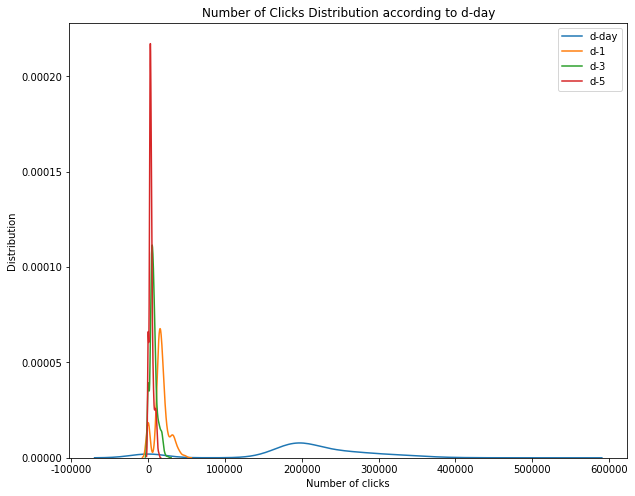

In [29]:
# 히스토그램을 통한 존 클릭 수 데이터의 분포 확인
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))

sns.kdeplot(df_click['click_d_day'])
sns.kdeplot(df_click['click_d_1'])
sns.kdeplot(df_click['click_d_3'])
sns.kdeplot(df_click['click_d_5'])

plt.legend(['d-day', 'd-1', 'd-3', 'd-5'])
plt.xlabel('Number of clicks')
plt.ylabel('Distribution')
plt.title('Number of Clicks Distribution according to d-day')
plt.show()

: 히스토그램을 봤을 때, **D-day의 click 수 분포가 가장 높은 구간에 위치**함을 알 수 있다. (약 20만개의 클릭) 이를 통해 회원의 대부분은 미리 예약하기 보다는, **이용 당일에 예약하는 패턴**을 보임을 알 수 있다.

**날씨 데이터의 기본 분포**

In [30]:
df_weather.describe()

,is_clean,avg_precipitation,avg_temperature,month,year
count,1238.000000,1238.000000,1238.000000,1238.000000,1238.00000
mean,0.226979,39.128110,12.927383,6.105008,2019.23021
std,0.419048,101.688929,9.180719,3.478348,0.99854
min,0.000000,0.000000,-11.300000,1.000000,2018.00000
25%,0.000000,0.000000,5.600000,3.000000,2018.00000
50%,0.000000,1.400000,13.000000,6.000000,2019.00000
75%,0.000000,19.300000,21.000000,9.000000,2020.00000
max,1.000000,1024.200000,30.500000,12.000000,2021.00000


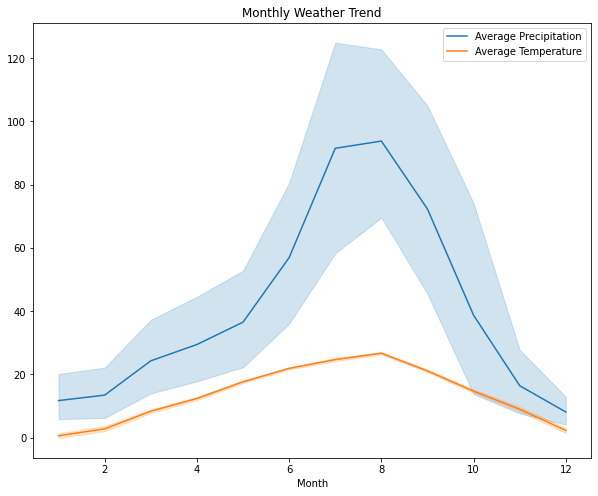

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))

sns.lineplot(
    data=df_weather,
    x='month',
    y='avg_precipitation',
    label='Average Precipitation'
)

sns.lineplot(
    data=df_weather,
    x='month',
    y='avg_temperature',
    label='Average Temperature'
)

plt.title('Monthly Weather Trend')
plt.xlabel('Month')
plt.ylabel('')
plt.show()

: 예상대로 여름에는 평균 강수량과 평균 기온이 높다.

**사전 가동률 데이터의 기본 분포**

In [32]:
df_pre.describe()

,op_rate_0d_all_cars,op_rate_1d_all_cars,op_rate_2d_all_cars,op_rate_3d_all_cars,op_rate_4d_all_cars,op_rate_5d_all_cars,op_rate_6d_all_cars,op_rate_7d_all_cars,op_rate_0d_major_cars,op_rate_1d_major_cars,op_rate_2d_major_cars,op_rate_3d_major_cars,op_rate_4d_major_cars,op_rate_5d_major_cars,op_rate_6d_major_cars,op_rate_7d_major_cars
count,939.000000,939.000000,939.000000,939.000000,939.000000,939.000000,939.000000,939.000000,939.000000,939.000000,939.000000,939.000000,939.000000,939.000000,939.000000,939.000000
mean,0.361281,0.164213,0.109605,0.085625,0.070207,0.058915,0.050080,0.043168,0.373451,0.167041,0.109600,0.084464,0.068381,0.056761,0.047681,0.040624
std,0.079082,0.052017,0.043476,0.037537,0.033096,0.029325,0.026288,0.024137,0.075612,0.052242,0.042528,0.036145,0.031512,0.027645,0.024564,0.022477
min,0.174715,0.039806,0.022272,0.017061,0.013667,0.011317,0.009533,0.007679,0.204501,0.041068,0.022316,0.015664,0.012037,0.009645,0.008158,0.005082
25%,0.315339,0.132602,0.079317,0.058178,0.045959,0.037512,0.030810,0.025605,0.323614,0.134492,0.080738,0.058374,0.045451,0.036878,0.029958,0.024426
50%,0.348765,0.162627,0.105795,0.081850,0.066181,0.054196,0.045335,0.038329,0.360241,0.165459,0.105375,0.080374,0.063985,0.052684,0.043206,0.036351
75%,0.410756,0.190794,0.132588,0.106823,0.087609,0.073784,0.063248,0.055452,0.421790,0.194873,0.131121,0.104106,0.085665,0.071535,0.060833,0.052804
max,0.718287,0.414606,0.359010,0.307167,0.272030,0.240116,0.209599,0.191690,0.726530,0.434607,0.360164,0.301955,0.259645,0.219954,0.194307,0.172045


: 사전 가동률 데이터는 컬럼이 많아서인지 한눈에 잘 들어오지 않는다.<br>
판다스의 **melt()**를 사용해서 **or_rate_0d_all_car**부터 **op_rate_7d_all_cars**의 여러 컬럼을 **op_value**라는 하나의 컬럼으로 merge


<br>
D-day부터 D-7까지의 날짜는 기준이 되는 컬럼인 d-day를 만들어서 확인할 수 있다.

In [33]:
df_pre_v1 = df_pre[['target_dates', 'op_rate_0d_all_cars', 'op_rate_1d_all_cars', 'op_rate_2d_all_cars', 'op_rate_3d_all_cars', 'op_rate_4d_all_cars', 'op_rate_5d_all_cars', 'op_rate_6d_all_cars', 'op_rate_7d_all_cars']]

df_pre_v1 = df_pre_v1.melt(
    id_vars='target_dates',
    value_vars=['op_rate_0d_all_cars', 'op_rate_1d_all_cars', 'op_rate_2d_all_cars', 'op_rate_3d_all_cars', 'op_rate_4d_all_cars', 'op_rate_5d_all_cars', 'op_rate_6d_all_cars', 'op_rate_7d_all_cars'],
    var_name='d-day',
    value_name='op_value',
)\
.replace('op_rate_0d_all_cars', 0)\
.replace('op_rate_1d_all_cars', 1)\
.replace('op_rate_2d_all_cars', 2)\
.replace('op_rate_3d_all_cars', 3)\
.replace('op_rate_4d_all_cars', 4)\
.replace('op_rate_5d_all_cars', 5)\
.replace('op_rate_6d_all_cars', 6)\
.replace('op_rate_7d_all_cars', 7)

df_pre_v1.head()

,target_dates,d-day,op_value
0,2019-11-20,0,0.316167
1,2019-04-07,0,0.433710
2,2020-09-20,0,0.470135
3,2019-11-28,0,0.320862
4,2021-06-26,0,0.444924


In [34]:
df_pre_v1[df_pre_v1['target_dates']=='2019-11-20']

,target_dates,d-day,op_value
0,2019-11-20,0,0.316167
939,2019-11-20,1,0.128829
1878,2019-11-20,2,0.073450
2817,2019-11-20,3,0.047983
3756,2019-11-20,4,0.041501
4695,2019-11-20,5,0.035837
5634,2019-11-20,6,0.028633
6573,2019-11-20,7,0.023602


: **target_dates**의 d-day를 0부터 7까지의 숫자로 확인할 수 있다.

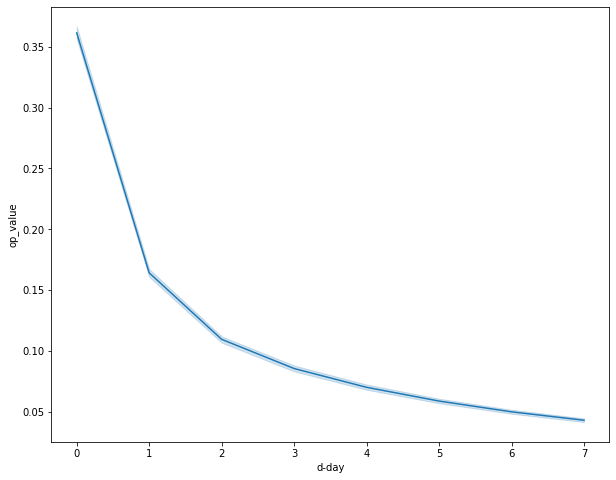

In [35]:
# lineplot을 통한 데이터의 분포 확인
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))

sns.lineplot(
    data=df_pre_v1,
    x='d-day',
    y='op_value'
)

plt.show()

: 그래프가 d-day로 갈수록 사전 가동률이 높아진다. d-day의 가동률이 가장 높은 것도 확인할 수 있다.

데이터를 정렬 후 재 확인

In [36]:
df_pre_v1 = df_pre_v1.sort_values(by='target_dates', ascending=True, ignore_index=True)
df_pre_v1.head()

,target_dates,d-day,op_value
0,2019-01-01,7,0.007968
1,2019-01-01,2,0.026660
2,2019-01-01,5,0.012905
3,2019-01-01,6,0.009968
4,2019-01-01,1,0.047908


In [37]:
df_pre_v1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7512 entries, 0 to 7511
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   target_dates  7512 non-null   datetime64[ns]
 1   d-day         7512 non-null   int64         
 2   op_value      7512 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 176.2 KB


: 가동률을 시기별로 보기 위해 **weeknum, year, yyyyww** 컬럼 추가.

In [38]:
df_pre_v1['weeknum'] = df_pre_v1['target_dates'].dt.isocalendar().week
df_pre_v1['year'] = df_pre_v1['target_dates'].dt.isocalendar().year
df_pre_v1['yyyyww'] = df_pre_v1['year'].astype(str) + '-' + df_pre_v1['weeknum'].astype(str)
df_pre_v1.head()

,target_dates,d-day,op_value,weeknum,year,yyyyww
0,2019-01-01,7,0.007968,1,2019,2019-1
1,2019-01-01,2,0.026660,1,2019,2019-1
2,2019-01-01,5,0.012905,1,2019,2019-1
3,2019-01-01,6,0.009968,1,2019,2019-1
4,2019-01-01,1,0.047908,1,2019,2019-1


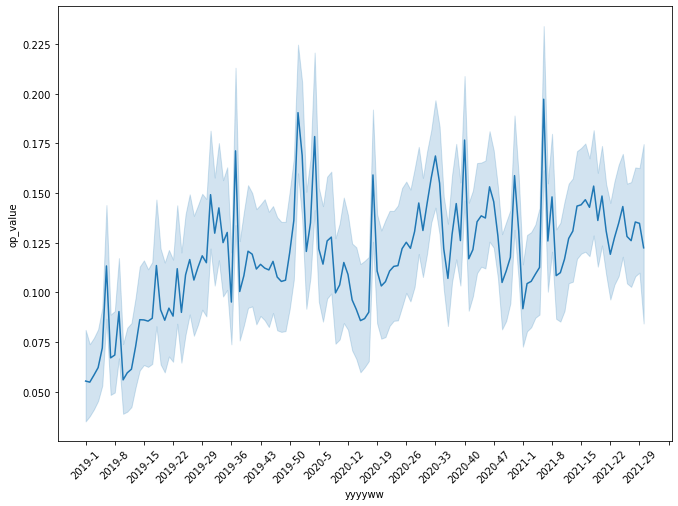

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))
plt.xticks(rotation=45)
loc = plticker.MultipleLocator(base=7.0)
ax.xaxis.set_major_locator(loc)

sns.lineplot(
    data=df_pre_v1,
    x='yyyyww',
    y='op_value',
)

plt.xticks(rotation=45)
plt.show()

: 사전 가동률 데이터의 분포를 보면 연휴기간, 연말~연초, 휴가철 등에 가동률이 증가함을 알 수 있다.

### 3. 상관관계 분석을 위한 준비

: 기본적인 EDA를 마무리 하였으며, 이제는 데이터의 features들이 어떤 상관관계를 가지는 확인해 볼 예정이다.


상관관계 분석이란 두 개의 연속 변수 간의 선형 관계를 분석하는 기법으로, 한 변수가 증가하면 나머지 변수도 선형적으로 증가 또는 감소하는지를 분석한다. 두 변수 사이의 선형 관계 정도를 상관계수(correlation coefficient)라고 부른다. 상관관계 분석은 회귀 분석이나 다른 분석을 위한 사전 단계로 사용되기도 한다.


주의해야 할 점은 상관관계가 있다고 해서 두 변수 사이에 인과관계가 존재한다는 뜻은 아니다. 즉, 설명 변수가 반응 변수를 예측할 때 유용할 수 있지만, 설명 변수가 반응 변수의 원인이라는 의미는 아니다. 반응 변수가 설명 변수의 원인이 될 수도 있고, 두 변수의 관계가 인과관계보다 더 복잡할 수도 있다.

**기간 세팅**

: 상관관계를 보기 전에 세 데이터의 기간이 일치하는지 살펴보고, 만약 기간이 다르면 기간을 맞출 예정이다.

In [40]:
# 각 데이터의 시작 날짜와 종료 날짜 확인
print(f"사전 가동률 데이터 시작 날짜: {df_pre_v1['target_dates'].unique().min()}")
print(f"존 클릭 수 데이터 시작 날짜: {df_click['target_dates'].unique().min()}")
print(f"날씨 데이터 시작 날짜: {df_weather['date'].unique().min()}")
print('\t')
print(f"사전 가동률 데이터 종료 날짜: {df_pre_v1['target_dates'].unique().max()}")
print(f"존 클릭 수 데이터 종료 날짜: {df_click['target_dates'].unique().max()}")
print(f"날씨 데이터 종료 날짜: {df_weather['date'].unique().max()}")

사전 가동률 데이터 시작 날짜: 2019-01-01T00:00:00.000000000
존 클릭 수 데이터 시작 날짜: 2019-08-31T00:00:00.000000000
날씨 데이터 시작 날짜: 2018-01-01T00:00:00.000000000
	
사전 가동률 데이터 종료 날짜: 2021-07-27T00:00:00.000000000
존 클릭 수 데이터 종료 날짜: 2021-10-24T00:00:00.000000000
날씨 데이터 종료 날짜: 2021-05-22T00:00:00.000000000


: 존 클릭 수 데이터의 시작 날짜가 2019년 8월 31일로 가장 늦고, 날씨 데이터의 종료 날짜가 2021년 5월 22일로 가장 빠르다.

In [41]:
df_click.head(20)

,target_dates,click_d_day,click_d_1,click_d_2,click_d_3,click_d_4,click_d_5,click_d_6,click_d_7
7,2019-08-31,33,0,0,0,0,0,0,0
8,2019-09-01,265846,0,0,0,0,0,0,0
9,2019-09-02,218807,6761,0,0,0,0,0,0
10,2019-09-03,208567,11582,2167,0,0,0,0,0
11,2019-09-04,207250,12927,5700,1279,0,0,0,0
12,2019-09-05,211608,12305,6835,3502,1307,0,0,0
13,2019-09-06,225281,14673,8554,6819,6041,1962,0,0
14,2019-09-07,243573,18392,12402,11697,12723,10323,2007,0
15,2019-09-08,295174,14536,8015,5475,5402,4175,3850,1190
16,2019-09-09,234512,12409,8536,5944,4645,3099,2392,1777


: 존 클릭 수 데이터의 모든 행이 채워진 날짜가 2019년 9월 8일이다. 따라서 모든 데이터 있는 날짜의 시작과 끝은

- 시작 날짜: 2019-09-08
- 종료 날짜: 2021-05-22

In [42]:
start_date = pd.to_datetime('2019-09-08', format='%Y-%m-%d')
end_date = pd.to_datetime('2021-05-22', format='%Y-%m-%d')
len(pd.date_range(start_date, end_date))

623

: 2019년 9월 8일부터 2021년 5월 22일까지는 총 623일이고, 사전 가동률 데이터, 존 클릭 수 데이터, 날씨 데이터 각각에 시작 날짜와 종료 날짜를 적용하면 각각 623개의 데이터가 있다는 걸 알 수 있다.

In [43]:
print(len(df_pre[(df_pre['target_dates']>=start_date) & (df_pre['target_dates']<=end_date)]['target_dates'].unique()))
print(len(df_click[(df_click['target_dates']>=start_date) & (df_click['target_dates']<=end_date)]['target_dates'].unique()))
print(len(df_weather[(df_weather['date']>=start_date) & (df_weather['date']<=end_date)]['date'].unique()))

623
623
623


In [44]:
# 기간을 맞춘 각각의 데이터를 merge()
df_pre_raws = df_pre[(df_pre['target_dates']>=start_date) & (df_pre['target_dates']<=end_date)]
df_click_raws = df_click[(df_click['target_dates']>=start_date) & (df_click['target_dates']<=end_date)]
df_weather_raws = df_weather[(df_weather['date']>=start_date) & (df_weather['date']<=end_date)]

In [45]:
df_raws_semi = df_pre_raws.merge(
    df_click_raws,
    how='left',
    left_on='target_dates',
    right_on='target_dates',
    copy=False,
)

df_raws = df_raws_semi.merge(
    df_weather_raws,
    how='left',
    left_on='target_dates',
    right_on='date',
    copy=False
)

df_raws.head()

,target_dates,op_rate_0d_all_cars,op_rate_1d_all_cars,op_rate_2d_all_cars,op_rate_3d_all_cars,op_rate_4d_all_cars,op_rate_5d_all_cars,op_rate_6d_all_cars,op_rate_7d_all_cars,op_rate_0d_major_cars,...,click_d_4,click_d_5,click_d_6,click_d_7,date,is_clean,avg_precipitation,avg_temperature,month,year
0,2019-11-20,0.316167,0.128829,0.073450,0.047983,0.041501,0.035837,0.028633,0.023602,0.354157,...,2211,1697,1650,1318,2019-11-20,0,0.0,3.0,11,2019
1,2020-09-20,0.470135,0.252650,0.181241,0.142521,0.117679,0.095518,0.076442,0.059885,0.469391,...,6179,4939,3808,1956,2020-09-20,1,0.0,18.9,9,2020
2,2019-11-28,0.320862,0.132336,0.075752,0.052990,0.038522,0.033602,0.029606,0.025020,0.358306,...,2139,1726,1693,1326,2019-11-28,0,32.1,5.1,11,2019
3,2020-08-31,0.313388,0.142075,0.100732,0.081107,0.063172,0.051917,0.040514,0.038404,0.319582,...,4970,3570,1909,1355,2020-08-31,0,22.2,26.0,8,2020
4,2019-10-16,0.334846,0.128528,0.074587,0.050741,0.042454,0.035131,0.026711,0.021401,0.356267,...,3192,2067,1701,1025,2019-10-16,1,0.0,13.8,10,2019


In [46]:
df_raws.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623 entries, 0 to 622
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   target_dates           623 non-null    datetime64[ns]
 1   op_rate_0d_all_cars    623 non-null    float64       
 2   op_rate_1d_all_cars    623 non-null    float64       
 3   op_rate_2d_all_cars    623 non-null    float64       
 4   op_rate_3d_all_cars    623 non-null    float64       
 5   op_rate_4d_all_cars    623 non-null    float64       
 6   op_rate_5d_all_cars    623 non-null    float64       
 7   op_rate_6d_all_cars    623 non-null    float64       
 8   op_rate_7d_all_cars    623 non-null    float64       
 9   op_rate_0d_major_cars  623 non-null    float64       
 10  op_rate_1d_major_cars  623 non-null    float64       
 11  op_rate_2d_major_cars  623 non-null    float64       
 12  op_rate_3d_major_cars  623 non-null    float64       
 13  op_ra

**date**은 컬럼은 필요 없으므로 삭제, **month, year, is_clean**의 데이터 타입을 int64로 변경하고 **week**컬럼 추가.

In [47]:
df_raws.drop(['date'], axis=1, inplace=True)
df_raws['month'] = df_raws['month'].astype(int)
df_raws['year'] = df_raws['year'].astype(int)
df_raws['is_clean'] = df_raws['is_clean'].astype(int)
df_raws['week'] = df_raws['target_dates'].dt.isocalendar().week

df_raws.head()

,target_dates,op_rate_0d_all_cars,op_rate_1d_all_cars,op_rate_2d_all_cars,op_rate_3d_all_cars,op_rate_4d_all_cars,op_rate_5d_all_cars,op_rate_6d_all_cars,op_rate_7d_all_cars,op_rate_0d_major_cars,...,click_d_4,click_d_5,click_d_6,click_d_7,is_clean,avg_precipitation,avg_temperature,month,year,week
0,2019-11-20,0.316167,0.128829,0.073450,0.047983,0.041501,0.035837,0.028633,0.023602,0.354157,...,2211,1697,1650,1318,0,0.0,3.0,11,2019,47
1,2020-09-20,0.470135,0.252650,0.181241,0.142521,0.117679,0.095518,0.076442,0.059885,0.469391,...,6179,4939,3808,1956,1,0.0,18.9,9,2020,38
2,2019-11-28,0.320862,0.132336,0.075752,0.052990,0.038522,0.033602,0.029606,0.025020,0.358306,...,2139,1726,1693,1326,0,32.1,5.1,11,2019,48
3,2020-08-31,0.313388,0.142075,0.100732,0.081107,0.063172,0.051917,0.040514,0.038404,0.319582,...,4970,3570,1909,1355,0,22.2,26.0,8,2020,36
4,2019-10-16,0.334846,0.128528,0.074587,0.050741,0.042454,0.035131,0.026711,0.021401,0.356267,...,3192,2067,1701,1025,1,0.0,13.8,10,2019,42


In [48]:
df_raws.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623 entries, 0 to 622
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   target_dates           623 non-null    datetime64[ns]
 1   op_rate_0d_all_cars    623 non-null    float64       
 2   op_rate_1d_all_cars    623 non-null    float64       
 3   op_rate_2d_all_cars    623 non-null    float64       
 4   op_rate_3d_all_cars    623 non-null    float64       
 5   op_rate_4d_all_cars    623 non-null    float64       
 6   op_rate_5d_all_cars    623 non-null    float64       
 7   op_rate_6d_all_cars    623 non-null    float64       
 8   op_rate_7d_all_cars    623 non-null    float64       
 9   op_rate_0d_major_cars  623 non-null    float64       
 10  op_rate_1d_major_cars  623 non-null    float64       
 11  op_rate_2d_major_cars  623 non-null    float64       
 12  op_rate_3d_major_cars  623 non-null    float64       
 13  op_ra

: 주말과 평일의 차이를 보기 위해 **weekday, is_weekend** 컬럼 추가

In [49]:
df_raws['weekday'] = df_raws['target_dates'].dt.weekday
df_raws['is_weekend'] = df_raws['weekday'] >= 5

In [53]:
# 프로젝트를 위한 데이터 저장
raws = pd.DataFrame(df_raws)
save_path = os.getenv('HOME') + '/aiffel/demand_forecasting/data/raws.csv'

raws.to_csv(save_path, index=False)

In [54]:
df_raws.head()

,target_dates,op_rate_0d_all_cars,op_rate_1d_all_cars,op_rate_2d_all_cars,op_rate_3d_all_cars,op_rate_4d_all_cars,op_rate_5d_all_cars,op_rate_6d_all_cars,op_rate_7d_all_cars,op_rate_0d_major_cars,...,click_d_6,click_d_7,is_clean,avg_precipitation,avg_temperature,month,year,week,weekday,is_weekend
0,2019-11-20,0.316167,0.128829,0.073450,0.047983,0.041501,0.035837,0.028633,0.023602,0.354157,...,1650,1318,0,0.0,3.0,11,2019,47,2,False
1,2020-09-20,0.470135,0.252650,0.181241,0.142521,0.117679,0.095518,0.076442,0.059885,0.469391,...,3808,1956,1,0.0,18.9,9,2020,38,6,True
2,2019-11-28,0.320862,0.132336,0.075752,0.052990,0.038522,0.033602,0.029606,0.025020,0.358306,...,1693,1326,0,32.1,5.1,11,2019,48,3,False
3,2020-08-31,0.313388,0.142075,0.100732,0.081107,0.063172,0.051917,0.040514,0.038404,0.319582,...,1909,1355,0,22.2,26.0,8,2020,36,0,False
4,2019-10-16,0.334846,0.128528,0.074587,0.050741,0.042454,0.035131,0.026711,0.021401,0.356267,...,1701,1025,1,0.0,13.8,10,2019,42,2,False


### 4. 상관관계 분석 -- 가동률과 존 클릭 수, 가동률과 날씨, 가동률과 요일

**가동률과 존 클릭 수**

: 먼저 가동률과 존 클릭 수의 상관관계를 알아본다. 예측할 대상인 반응 변수는 **최종 가동률('op_rate_0d_all_cars')**이고, 설명 변수는 **존 클릭 수**이다.

연속형 변수에 사용되는 피어슨 상관 분석을 통해 두 변수 간 상관관계를 확인.

In [55]:
click_d_days = ['click_d_day', 'click_d_1', 'click_d_2', 'click_d_3', 'click_d_4', 'click_d_5', 'click_d_6', 'click_d_7']

corr_values = []

for temp_click_d_day in click_d_days:
    temp_corr_value = df_raws['op_rate_0d_all_cars'].corr(df_raws[temp_click_d_day], method='pearson')
    corr_values.append(temp_corr_value)
    
df_corr_op_click = pd.DataFrame([click_d_days, corr_values], index=['with_variable', 'corr']).T
df_corr_op_click

,with_variable,corr
0,click_d_day,0.853494
1,click_d_1,0.800474
2,click_d_2,0.722905
3,click_d_3,0.685922
4,click_d_4,0.702857
5,click_d_5,0.720104
6,click_d_6,0.691809
7,click_d_7,0.583855


: 상관관계의 정도를 나타내는 상관계수(correlation coefficient)는 -1부터 1까지의 값을 가진다. 상관계수의 절대값의 크기는 직선 관계(선형 관계)에 가까운 정도이고, 부호는 직선 관계의 방향이다. 즉, 상관계수가 -1에 가까울수록 강한 음의 상관관계, 1에 가까울수록 강한 양의 상관관계라고 할 수 있다. 반면 상관계수가 0에 가까울수록 상관관계가 매우 약함을 의미한다.

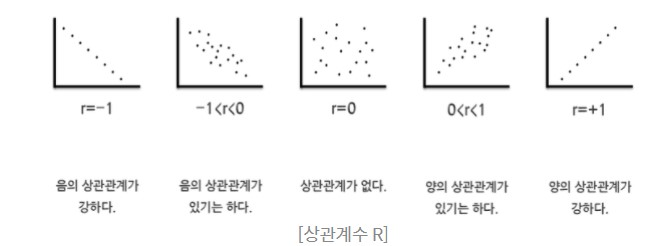

<div align='center'>

<https://bkshin.tistory.com/entry/DATA-17-Regression>
    </div>

: 표를 통해 보면 존 클릭 수와 가동률이 대부분 양의 상관관계를 가지고, d-day로 갈수록 점점 강한 상관관계를 보이고 있다.

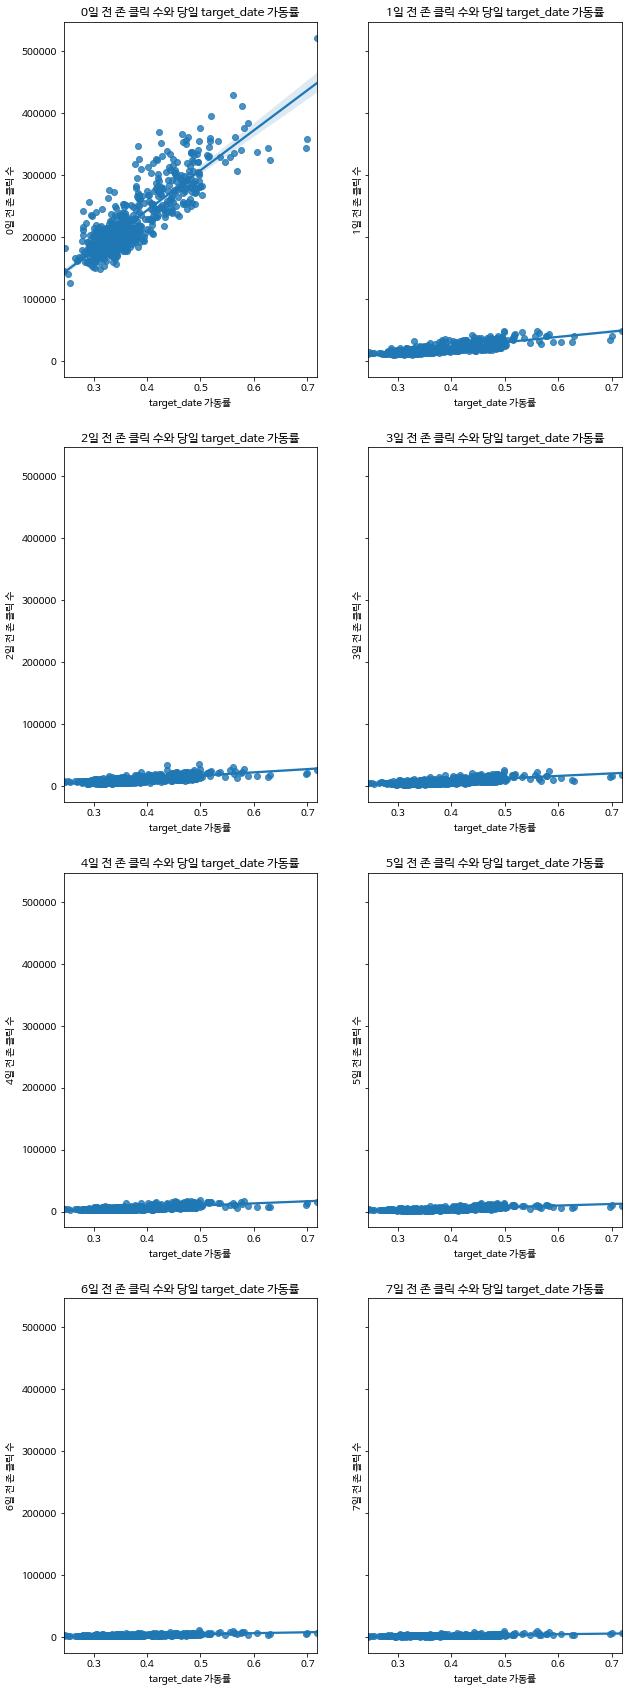

In [61]:
# 산점도를 통한 시각화
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10, 30), sharey=True)

for i, temp_click_d_day in enumerate(click_d_days):
    row = i // 2
    col = i % 2
    sns.regplot(
        ax=axs[row, col],
        data=df_raws,
        x='op_rate_0d_all_cars',
        y=f'{temp_click_d_day}'
    )
    
    axs[row, col].set_title(f'{i}일 전 존 클릭 수와 당일 target_date 가동률')
    axs[row, col].set_xlabel('target_date 가동률')
    axs[row, col].set_ylabel(f'{i}일 전 존 클릭 수')
    
plt.show()


: N일 전 클릭 수와 당일 가동률간의 상관관계는 D-day가 가까워질수록 선형으로 설명할 수 있는 비중이 커지는 것으로 관측된다.

**가동률과 날씨**

: 반응 변수는 **최종 가동률('op_rate_0d_all_cars')**이고, 설명 변수는 **평균 기온, 평균 강수량, 강수 여부**이다. 피어슨 상관 분석을 사용할 예정이다.

In [65]:
weather_variables = ['is_clean', 'avg_precipitation', 'avg_temperature']

corr_values = []

for temp_weather_variable in weather_variables:
    temp_corr_value = df_raws['op_rate_0d_all_cars'].corr(df_raws[temp_weather_variable], method='pearson')
    corr_values.append(temp_corr_value)
    
df_corr_weather = pd.DataFrame([weather_variables, corr_values], index=['with_variable', 'corr']).T
df_corr_weather

,with_variable,corr
0,is_clean,-0.048002
1,avg_precipitation,-0.104195
2,avg_temperature,0.052604


: 뚜렷한 상관관계가 잘 보이지 않는다. 하지만 **뚜렷한 상관관계가 없다고 해서 의미 없는 변수라는 뜻은 아니다.** 특히 여러 개의 설명 변수를 가지고 있을 때는 섣불리 판단하면 안된다.

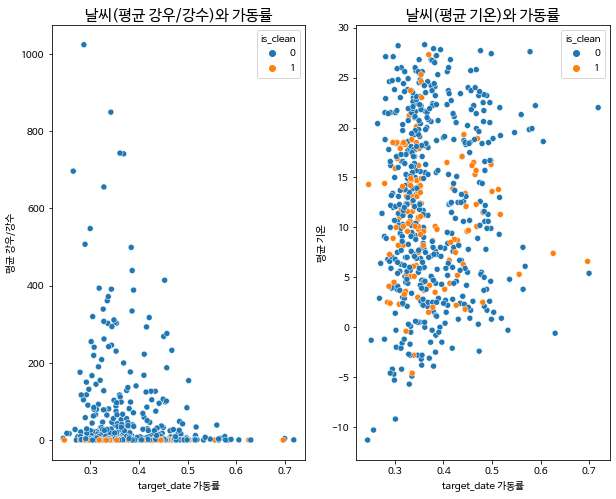

In [66]:
# 산점도를 통한 시각화
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,8))

sns.scatterplot(
    ax=axs[0],
    data=df_raws,
    x='op_rate_0d_all_cars',
    y='avg_precipitation',
    hue='is_clean'
)
axs[0].set_title('날씨(평균 강우/강수)와 가동률', fontsize=15)
axs[0].set_xlabel('target_date 가동률')
axs[0].set_ylabel('평균 강우/강수')

sns.scatterplot(
    ax=axs[1],
    data=df_raws,
    x='op_rate_0d_all_cars',
    y='avg_temperature',
    hue='is_clean'
)
axs[1].set_title('날씨(평균 기온)와 가동률', fontsize=15)
axs[1].set_xlabel('target_date 가동률')
axs[1].set_ylabel('평균 기온')

plt.show()

: 시각화를 통해 봐도 특별한 상관관계를 확인 할 수 없다. 하지만 맑은 날보다 비가 오는 날에 가동률이 더 높은 것을 알 수 있다.

**가동률과 요일**

: 반응 변수는 **최종 가동률('op_rate_0d_all_cars')**이고, 설명 변수는 **요일('weekday')과 주말 여부('is_weekend')**이다. 요일과 주말 여부를 **groupby()**로 묶어서 요일별 평균 가동률과 평일과 주말의 평균 가동률을 확인해 볼 예정이다.

In [67]:
# weekday의 값으로 0은 월요일, 1은 화요일, ..., 6은 일요일
df_raws[['op_rate_0d_all_cars', 'weekday']].groupby(['weekday']).mean()

,op_rate_0d_all_cars
weekday,
0,0.322683
1,0.338987
2,0.351809
3,0.358927
4,0.364407
5,0.458155
6,0.434354


In [68]:
df_raws[['op_rate_0d_all_cars', 'is_weekend']].groupby(['is_weekend']).mean()

,op_rate_0d_all_cars
is_weekend,
False,0.347362
True,0.446255


: 평일과 주말 중 주말의 가동률이 조금 더 높지만 평일과 아주 큰 차이는 보이지 않는다. 바이올린 플롯을 그려서 시각화로 조금 더 자세히 확인해 볼 예정이다.

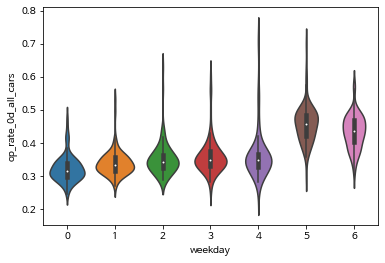

In [69]:
sns.violinplot(
    data=df_raws,
    x='weekday',
    y='op_rate_0d_all_cars'    
)

plt.show()

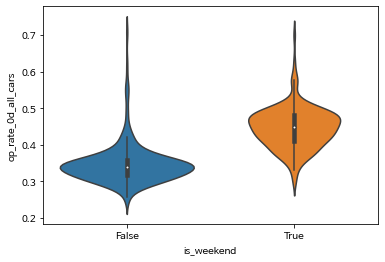

In [71]:
sns.violinplot(
    data=df_raws,
    x='is_weekend',
    y='op_rate_0d_all_cars'    
)

plt.show()

: 일주일 중 토요일의 가동률이 가장 높고, 평일에는 비슷비슷하다. 평일과 주말 중에는 주말의 가동률이 높은 것을 쉽게 파악할 수 있다.

> 이와 같이 시각화를 통해 가동률(연속형 변수)과 요일(범주형 변수)의 상관관계를 확인했지만, 상관계수를 통해서 확인해볼 수도 있다. 즉, '연속형-연속형'뿐만 아니라 '연속형-범주형', '범주형-범주형'의 변수 관계를 수치화하는 상관계수도 존재한다.

### 5. 선형 회귀 분석의 이해

: 선형 회귀 분석은 반응 변수(또는 종속 변수)와 한 개 이상의 설명 변수(또는 독립 변수)와의 선형 상관관계를 모델링하는 회귀분석 기법이다. 독립 변수가 1개라면 (단순) 선형 회귀, 2개 이상이라면 다중 선형 회귀라고 부른다. 선형 회귀식은 아래와 같다.

- 단순 선형 회귀식

$$ y = \alpha_0 + \alpha_1x + \in $$

- 다중 선형 회귀식

$$ y = \alpha_0 + \alpha_1x_1 + \alpha_2x_2 + ... + \alpha_nx_n + \in $$

$$ (x,x_n:설명 변수, y: 반응 변수, \alpha_0: y절편, \alpha_n: 회귀계수, \in:오차항) $$

: 선형 회귀 그래프로 산점도를 많이 사용하는데, 산점도에서 데이터들의 경향을 알고 싶을 때 주로 추세선을 그린다. 아래 그림의 빨간색 실선이 추세선이다.

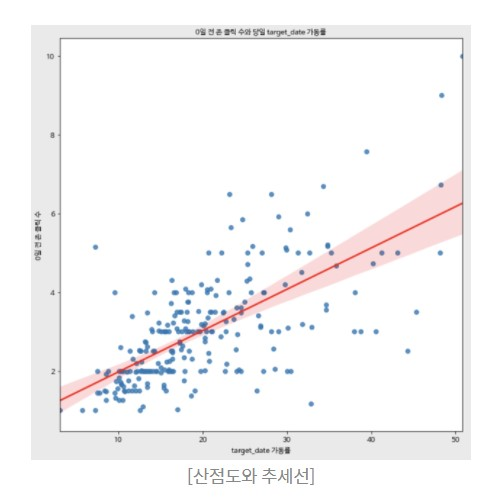

: 최적의 추세선을 그리기 위한 방법 중에 최소제곱법(Least Squares Method 또는 Ordinary Least Squares Method: OLS)이 있다.<br>
데이터의 y값(실제값)과 추세선의 y값의 차를 잔차(residual)라고 하는데, 최소제고법은 이 잔차의 합을 최소로 하는 방법이다.

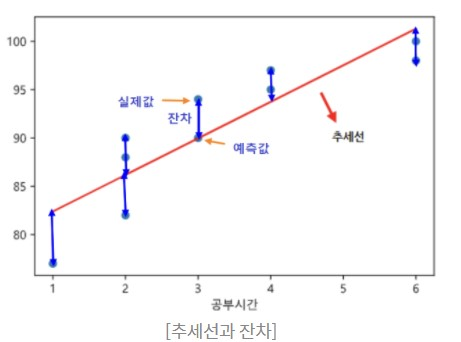

<https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=9300420&logNo=222081938010>

잔차의 제곱의 합은 그림에 나타난 사각형들의 넓이의 합이라고 생각할 수도 있다. 왼쪽 그래프의 사각형들의 넓이의 합이 오른쪽 그래프의 사각형들의 넓이의 합보다 작듯이 최소제곱법을 사용하여 데이터를 가장 잘 표현하는 선형회귀선을 그릴 수 있다.

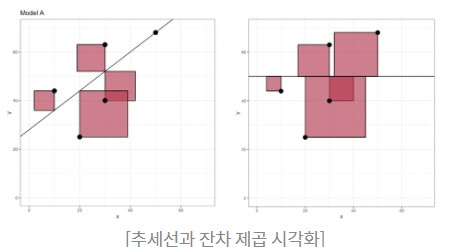

<https://zief0002.github.io/modeling/ordinary-least-squares-ols-estimation.html>

**모형과 가정 검증**

- 모형

: **stats.model** 라이브러리를 사용해 OLS 선형 회귀 검정을 하면 아래와 같은 표가 나온다.

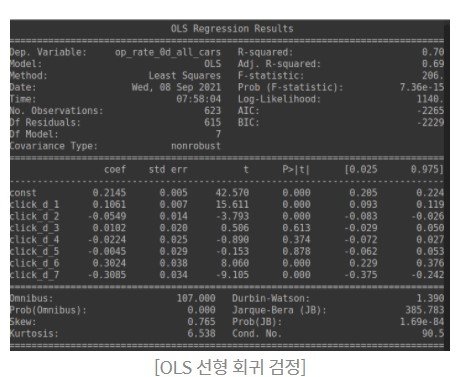

: 위의 표에서 중요한 정보는 'coef, p-value, R^2' 이다.

coef의 여러 행 중 const는 y절편이고, 존 클릭 수 옆에 적힌 숫자들이 회귀계수이다. 예를 들어 **click_d_1**의 경우, 선형 회귀식은 **y = 0.2145 + 0.1061x**이다. y절편의 p-value는 0, **click_d_1**의 p-value 역시 0으로, **click_d_1**에 대한 정보는 통계적으로 유의미하다는 것을 알 수 있다. 같은 방식으로 **click_d_2**부터 **click_d_7**까지의 선형 회귀식을 구할 수 있다.

p-value는 '관측된 값이 통계값과 차이가 없거나 의미 있는 차이가 없다'는 귀무가설(null hypothesis)이 맞다고 전제할 때, 통계값이 실제로 관측된 값 이상일 확률이다. 관측된 값이 귀무가설과 반대되는 정도를 0과 1사이로 표현하고, p-value가 특정 값(0.05나 0.01 등)보다 작으면 귀무가설을 기각한다. 일반적으로 유의수준 0.05미만으로 나타나면 '유의미(significant)한 차이가 있다'라고 볼 수 있다.

R^2은 결정계수(coefficient of determination) 또는 설명력이라고 부른다. 회귀 모형에서 설명 변수가 반응 변수를 설명하는 정도를 알려주는 지표이다. 0과 1사이의 값을 가지며, 결정계수가 1에 가까울수록 설명 변수가 반응 변수를 많이 설명한다고 볼 수 있다. 위의 표에서 R^2가 0.701이므로 설명 변수인 존 클릭 수가 반응 변수인 가동률('op_rate_0d_all_cars')의 약 70% 정도를 설명한다고 할 수 있다. 다만 설명 변수가 두 개 이상인 다중 선형 회귀 분석에서는 수정 결정계수(Adjusted Coefficent of determination. adj. R-squared)를 사용한다. 반응 변수의 변화를 설명하지 못하는 설명 변수가 모형에 추가되어도 결정계수의 값이 커질 수 있다는 사실을 고려하여 고안된 지표이다. 

**가설 검증**

: 선형 회귀 분석에는 기본 가정 4가지가 존재한다.
<br>
잔차의 독립성, 잔차의 정규성, 잔차의 등분산성, 모형의 선형성
<br>
이 가정을 만족할 때 회귀 모형의 예측력이 좋다고 볼 수 있다.

**a. 잔차의 독립성**

: 잔차의 독립성이란 잔차가 서로 상관관계가 없이 독립적이라는 뜻이다.

잔차가 서로 상관관계를 가지면 회귀 분석의 결과값이 아무 의미를 갖지 못하기 때문에 잔차가 서로 독립적인지 알아봐야 한다. 잔차의 독립성은 **Durbin-Watson(DW) 검정**로 확인할 수 있다.

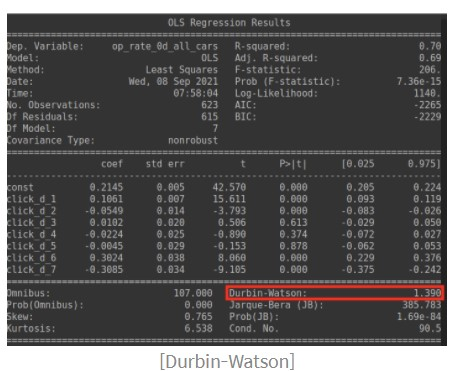

: DW는 OLS 선형 회귀 검정의 결과로 나온 표에 나온다. 위의 그림에서 빨간색 네모 박스 안에 DW값이 나와 있다.

DW 값에 따라
- 1.5 ~ 2.5: 잔차는 자기 상관을 갖지 않는다. (독립적)
- 0.0 ~ 1.5: 잔차는 양의 자기 상관을 가진다.
- 2.5 ~ 4.0: 잔차는 음의 자기 상관을 가진다.


라고 판단할 수 있다. 또한 0과 4에 가까워 질수록 회귀 모형에 잔차가 많이 존재해 회귀 모형이 적하하지 않다고 볼 수 있다.


**b. 잔차의 정규성**

: 잔차의 정규성은 잔차가 정규분포를 따른다는 의미이다.

잔차의 정규성은 **Q-Q plot이나 Shapiro-Wilk 검정** 등 으로 확인할 수 있다. 아래의 그림과 같이 **Q-Q plot에서 잔차가 대각선 방향의 직선 형태를 띠면, 즉 점들이 점선을 따라 있으면 잔차가 정규분포**를 따른다는 의미이다.

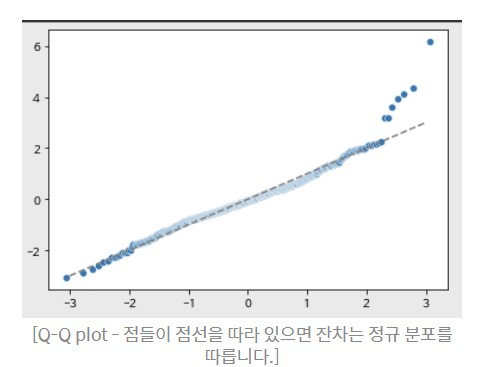

: Shapiro-Wilk 검정에서는 잔차가 정규분포를 따른다고 귀무가설(H0), 잔차가 정규분포를 따르지 않는다는 대립가설(H1)을 설정한다. 검정을 실행했을 때, 귀무가설이 기각되고 대립가설이 채택되면 잔차가 정규분포를 따르지 않는다는 것을 알 수 있다.

**c. 잔차의 등분산성**

: 잔차의 등분산성은 회귀 모형을 통해 예측된 값은 모든 값들에 대하여 잔차의 분산이 동일하다는 의미이다.

잔차의 등분산성은 산점도를 통해 확인할 수 있다. 그래프는 예측값(x축)에 따라 잔차가 어떻게 달라지는지 보여준다. 정상적인 잔차는 0을 기준으로 y값에 관계없이 특정한 패턴을 가지지 않는다. 그러나 부채꼴 모양이나 고리처럼 특정한 패턴을 보이면 잔차는 등분산성을 만족하지 않는다.

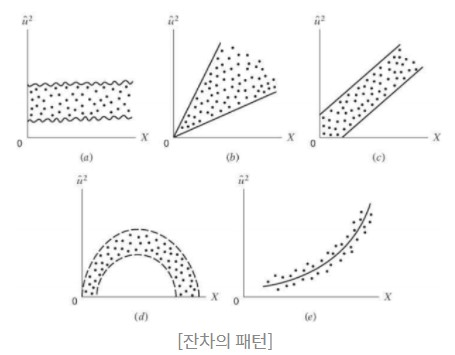

<https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=wjddudwo209&logNo=220176239447>

간단하게 **잔차의 추세(빨간색 실선)가 수평선에 가까울수록 등분산성이 있다**고 풀이할 수 있다.

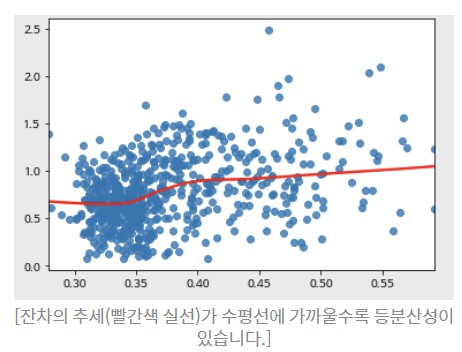

**d. 모형의 선형성**

: 모형의 선형성은 반응 변수와 설명 변수가 선형 관계를 가진다는 가정이다.

모형의 선형성을 가지는지 알아보려면 예측값과 잔차를 비교해야 한다. 모든 예측값에서 가운데 점선에 맞추어 잔차가 비슷하게 있어야 한다. 산점도에서 빨간색 실선은 잔차의 추세를 나타낸다. **잔차의 추세(빨간색 실선)가 점선에서 크게 벗어난다면 예측값에 따라 잔차가 크게 달라진다**는 것으로, 선형성이 떨어진다고 풀이할 수 있다.

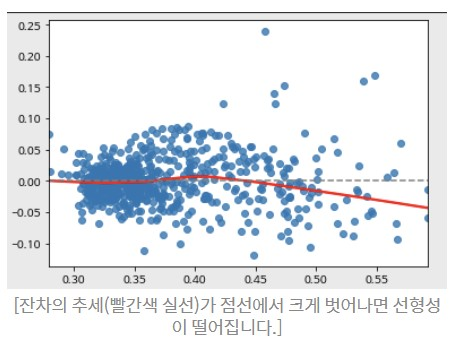

- [선형 회귀분석의 4가지 기본가정](https://kkokkilkon.tistory.com/175)

### 6. 선형 회귀 분석

: **가동률과 존 클릭 수, 가동률과 날씨, 가동률과 요일, 가동률과 존 클릭 수 및 날씨(다중 회귀)** 순으로 진행.(각 회귀 분석이 선형 회귀 분석의 기본 가정 4 가지를 충족하는지 검증)

**1) 가동률과 존 클릭 수**

**모형**

: **stats.model** 라이브러리를 사용해 최소자승법 사용.<br>
먼저 설명 변수를 존 클릭 수 전체, 예측할 변수(반응 변수)를 가동률(**op_rate_0d_all_cars**)로 정의함. 그리고 y절편(상수항)을 추가.

In [72]:
df_raws.sort_values(by='target_dates', inplace=True)

In [73]:
# 설명 변수 테이블 설정
_x_data = df_raws[['click_d_day', 'click_d_1', 'click_d_2', 'click_d_3', 'click_d_4', 'click_d_5', 'click_d_6', 'click_d_7']]

# 예측 대상 데이터 설정
target = df_raws['op_rate_0d_all_cars']

# 상수항 추가
x_data = sm.add_constant(_x_data, has_constant='add')

# OLS 선형회귀 검정
model = sm.OLS(target, x_data)
model_fit = model.fit()

# 결과물 출력
print(model_fit.summary())

                             OLS Regression Results                            
Dep. Variable:     op_rate_0d_all_cars   R-squared:                       0.765
Model:                             OLS   Adj. R-squared:                  0.762
Method:                  Least Squares   F-statistic:                     250.1
Date:                 Wed, 16 Mar 2022   Prob (F-statistic):          1.47e-187
Time:                         05:33:27   Log-Likelihood:                 1215.1
No. Observations:                  623   AIC:                            -2412.
Df Residuals:                      614   BIC:                            -2372.
Df Model:                            8                                         
Covariance Type:             nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1389      0.007     18

: 당일 이전, 즉 적어도 1일 전에 가동률을 예측할 것이라면 d-day의 존 클릭 수는 설명 변수로 넣을 수 없다. **d-day의 존 클릭 수는 제외하고 모델링**

In [74]:
# 설명 변수 테이블 설정
_x_data = df_raws[['click_d_1', 'click_d_2', 'click_d_3', 'click_d_4', 'click_d_5', 'click_d_6', 'click_d_7']]

# 예측 대상 데이터 설정
target = df_raws['op_rate_0d_all_cars']

# 상수항 추가
x_data = sm.add_constant(_x_data, has_constant='add')

# OLS 선형회귀 검정
model = sm.OLS(target, x_data)
model_fit = model.fit()

# 결과물 출력
print(model_fit.summary())

                             OLS Regression Results                            
Dep. Variable:     op_rate_0d_all_cars   R-squared:                       0.701
Model:                             OLS   Adj. R-squared:                  0.698
Method:                  Least Squares   F-statistic:                     206.5
Date:                 Wed, 16 Mar 2022   Prob (F-statistic):          7.36e-157
Time:                         05:34:34   Log-Likelihood:                 1140.4
No. Observations:                  623   AIC:                            -2265.
Df Residuals:                      615   BIC:                            -2229.
Df Model:                            7                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2145      0.005     42.57

: 존 클릭 수는 가동률이나 평균 기온과 달리 크기가 크기 때문에 설명 변수를 스케일링(scaling, 상수배)한다. 이때 **stats.model**의 condition number는 스케일링에 민감한 저오이므로 유의해야한다.

In [75]:
# 설명 변수 테이블 설정
_x_data = df_raws[['click_d_1', 'click_d_2', 'click_d_3', 'click_d_4', 'click_d_5', 'click_d_6', 'click_d_7']][:]
_x_data /= 10000  

# 예측 대상 데이터 설정
target = df_raws['op_rate_0d_all_cars']

# 상수항 추가
x_data = sm.add_constant(_x_data, has_constant='add')

# OLS 선형회귀 검정
model = sm.OLS(target, x_data)
model_fit = model.fit()

# 결과물 출력
print(model_fit.summary())

                             OLS Regression Results                            
Dep. Variable:     op_rate_0d_all_cars   R-squared:                       0.701
Model:                             OLS   Adj. R-squared:                  0.698
Method:                  Least Squares   F-statistic:                     206.5
Date:                 Wed, 16 Mar 2022   Prob (F-statistic):          7.36e-157
Time:                         05:36:03   Log-Likelihood:                 1140.4
No. Observations:                  623   AIC:                            -2265.
Df Residuals:                      615   BIC:                            -2229.
Df Model:                            7                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2145      0.005     42.57

: R^2가 0.701이므로 설명 변수인 존 클릭 수가 반응 변수인 가동률(op_rate_0d_all_cars)의 약 70% 정도를 설명한다고 할 수 있다.

**가정 검증**

: 설명 변수의 추정치와 잔차를 먼저 구한다.

In [77]:
# 가설 검증 재료
ols_pred = model_fit.fittedvalues  # 추정치

residual = model_fit.resid  # 잔차

**a. 잔차의 독립성**

: OLS 회귀 결과(OLS Regression Result)에 따르면 DW 값은 1.390이므로 잔차는 **양의 자기상관**을 가진다고 할 수 있다.

**b. 잔차의 정규성**

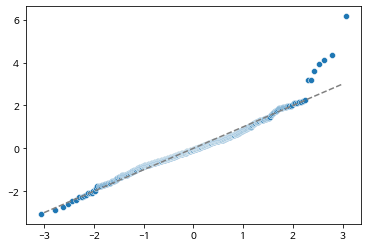

In [79]:
sr = scipy.stats.zscore(residual)

(x, y), _ = scipy.stats.probplot(sr)

sns.scatterplot(x=x, y=y)
plt.plot(
    [-3, 3],
    [-3, 3],
    '--',
    color='grey'
)
plt.show()

: Q-Q plot에서 잔차들이 대체로 점선을 따라 배치되어 있다.<br>
하지만 점선에서 벗어나는 잔차도 보인다. Shapiro 검정의 결과도 확인해야 할 듯 하다.

In [80]:
# 잔차의 정규성 검정: shapiro 검정
# 귀무가설: 잔차의 정규성이 만족한다.
result = scipy.stats.shapiro(residual)
print(f'# 검정 통계량: {result[0]: .5f}')
print(f'# 유의 수준: {result[1]: .5f}')

# 검정 통계량:  0.96041
# 유의 수준:  0.00000


: 유의 수준 5%를 가정할 경우, p=0.00000이므로 **유의 수준 5%에서 잔차의 정규성을 만족한다는 귀무가설을 기각**할 수 있다. 즉 잔차가 정규성을 만족하지 않는다.

**c. 잔차의 등분산성**

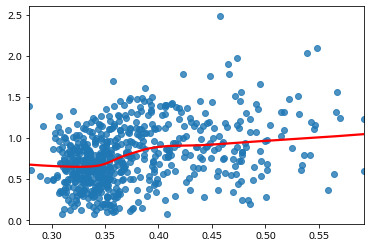

In [82]:
sns.regplot(
    x=ols_pred,
    y=np.sqrt(np.abs(sr)),
    lowess=True,
    line_kws={'color':'red'}    
)
plt.show()

: 잔차의 추세(빨간색 실선)가 수평선에서 조금 벗어나 보임.

**d. 모형의 선형성**

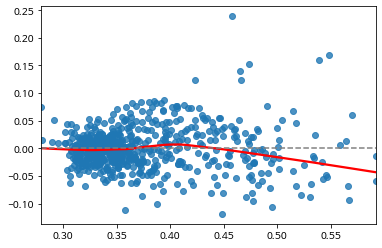

In [83]:
sns.regplot(
    x=ols_pred,
    y=residual,
    lowess=True,
    line_kws={'color':'red'}
)

plt.plot(
    [ols_pred.min(), ols_pred.max()],
    [0, 0],
    '--',
    color='grey'
)
plt.show()

: 잔차의 추세(빨간색 실선)가 점선과 비슷한 부분도 있지만 점선에서 벗어나는 부분도 있다.

**2) 가동률과 날씨**

**모형**

In [84]:
# 설명 변수 테이블 설정
_x_data = df_raws[['is_clean', 'avg_precipitation', 'avg_temperature']]

# 예측 대상 데이터 설정
target = df_raws['op_rate_0d_all_cars']

# 상수항 추가
x_data = sm.add_constant(_x_data, has_constant='add')

# OLS 선형회귀 검정
model = sm.OLS(target, x_data)
model_fit = model.fit()

# 결과물 출력
print(model_fit.summary())

                             OLS Regression Results                            
Dep. Variable:     op_rate_0d_all_cars   R-squared:                       0.023
Model:                             OLS   Adj. R-squared:                  0.019
Method:                  Least Squares   F-statistic:                     4.944
Date:                 Wed, 16 Mar 2022   Prob (F-statistic):            0.00212
Time:                         05:47:31   Log-Likelihood:                 771.19
No. Observations:                  623   AIC:                            -1534.
Df Residuals:                      619   BIC:                            -1517.
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.3725

: 회귀직선의 R^2값이 굉장히 낮다. 기온이 너무 높거나 낮을 때 가동률이 낮아질 수 있으므로 기온의 2차항까지 회귀식에 포함시켜 봐야한다. 회귀식은 보통 1차식(직선)이지만 2차항을 넣어주면 곡선관계도 분석할 수 있다.

In [85]:
# 제곱 항 생성
df_raws['avg_temperature_sq'] = df_raws['avg_temperature'] ** 2

# 설명 변수 테이블 설정
_x_data = df_raws[['is_clean', 'avg_precipitation', 'avg_temperature', 'avg_temperature_sq']]

# 예측 대상 데이터 설정
target = df_raws['op_rate_0d_all_cars']

# 상수항 추가
x_data = sm.add_constant(_x_data, has_constant='add')

# OLS 선형회귀 검정
model = sm.OLS(target, x_data)
model_fit = model.fit()

# 결과물 출력
print(model_fit.summary())

                             OLS Regression Results                            
Dep. Variable:     op_rate_0d_all_cars   R-squared:                       0.026
Model:                             OLS   Adj. R-squared:                  0.020
Method:                  Least Squares   F-statistic:                     4.158
Date:                 Wed, 16 Mar 2022   Prob (F-statistic):            0.00249
Time:                         05:48:45   Log-Likelihood:                 772.08
No. Observations:                  623   AIC:                            -1534.
Df Residuals:                      618   BIC:                            -1512.
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.3

: 2차항을 넣어주어도 R^2이 여전히 낮기 때문에 날씨가 가동률을 예측하는데에 큰 도움이 되지 않음을 확인할 수 있다.

**가정 검증**

In [89]:
# 가설 검증 재료
ols_pred = model_fit.fittedvalues

residual = model_fit.resid

**a. 잔차의 독립성**

OLS 회귀 결과에 따르면 DW 값은 0.993이므로 잔차는 **양의 자기 상관**을 가진다고 판단할 수 있다.

**b. 잔차의 정규성**

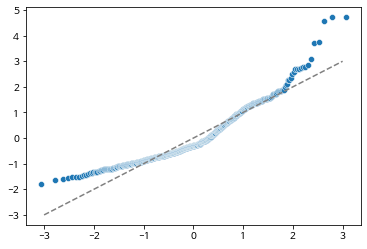

In [90]:
sr = scipy.stats.zscore(residual)

(x, y), _ = scipy.stats.probplot(sr)

sns.scatterplot(x=x, y=y)
plt.plot(
    [-3, 3],
    [-3, 3],
    '--',
    color='grey'
)
plt.show()

In [91]:
# 잔차의 정규성 검정: shapiro 검정
# 귀무가설: 잔차의 정규성이 만족한다
result = scipy.stats.shapiro(residual)
print( f'# 검정 통계량: {result[0]: .5f}')
print( f'# 유의 수준:  {result[1]: .5f}')

# 검정 통계량:  0.91090
# 유의 수준:   0.00000


: 유의 수준 5%를 가정할 경우, P = 0.00000이므로 **유의 수준 5%에서 잔차의 정규성을 만족한다는 귀무가설을 기각**할 수 있다. Q-Q plot에서도 잔차들이 점서에서 벗어나 있다.

**c. 잔차의 등분산성**

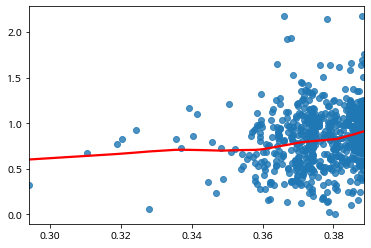

In [92]:
sns.regplot(
    x=ols_pred,
    y=np.sqrt(np.abs(sr)),
    lowess=True,
    line_kws={'color':'red'}    
)
plt.show()

: 잔차의 추세(빨간색 실선)가 수평선에서 조금 벗어나 있다.

**d. 모형의 선형성**

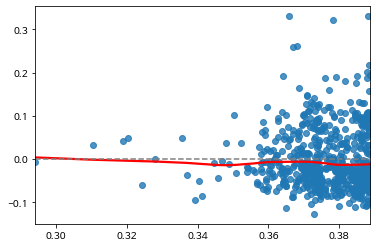

In [93]:
sns.regplot(
    x=ols_pred,
    y=residual,
    lowess=True,
    line_kws={'color':'red'}
)

plt.plot(
    [ols_pred.min(), ols_pred.max()],
    [0, 0],
    '--',
    color='grey'
)
plt.show()

: 잔차의 추세(빨간색 실선)가 점선과 거의 비슷하다. 가동률과 날씨 모형은 선형성을 띠고 있다.

**3) 가동률과 요일**

**모형**

In [94]:
# 설명 변수 테이블 설정
_x_data = df_raws[['weekday']][:]

# Dummy variable 생성
_x_data = pd.get_dummies(_x_data['weekday'], prefix='weekday', drop_first=False)

# 예측 대상 데이터 설정
target = df_raws['op_rate_0d_all_cars']

# 상수항 추가
x_data = sm.add_constant(_x_data, has_constant='add')

# OLS 선형회귀 검정
model = sm.OLS(target, x_data)
model_fit = model.fit()

# 결과물 출력
print(model_fit.summary())

                             OLS Regression Results                            
Dep. Variable:     op_rate_0d_all_cars   R-squared:                       0.436
Model:                             OLS   Adj. R-squared:                  0.430
Method:                  Least Squares   F-statistic:                     79.26
Date:                 Wed, 16 Mar 2022   Prob (F-statistic):           2.70e-73
Time:                         05:55:04   Log-Likelihood:                 942.04
No. Observations:                  623   AIC:                            -1870.
Df Residuals:                      616   BIC:                            -1839.
Df Model:                            6                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3287      0.002    174.77

: R^2가 0.436이므로 요일이 가동률을 약 40% 정도 설명한다고 볼 수 있다.

**감설 검증**

In [96]:
# 가설 검증 재료
ols_pred = model_fit.fittedvalues

residual = model_fit.resid

**a. 잔차의 독리성**

: OLS 회귀 결과에 따르면 DW 값은 0.605이므로 잔차는 **양의 자기 상관**을 가진다고 판단할 수 있다.

**b. 잔차의 정규성**

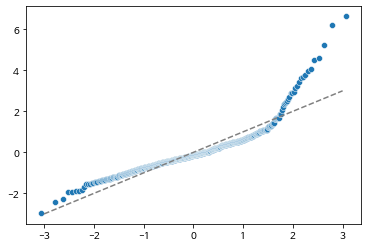

In [97]:
sr = scipy.stats.zscore(residual)

(x, y), _ = scipy.stats.probplot(sr)

sns.scatterplot(x=x, y=y)
plt.plot(
    [-3, 3],
    [-3, 3],
    '--',
    color='grey'
)
plt.show()

In [98]:
# 잔차의 정규성 검정: shapiro 검정
# 귀무가설: 잔차의 정규성이 만족한다
result = scipy.stats.shapiro(residual)
print( f'# 검정 통계량: {result[0]: .5f}')
print( f'# 유의 수준:  {result[1]: .5f}')

# 검정 통계량:  0.84576
# 유의 수준:   0.00000


: 유의 수준 5%를 가정할 경우, p=0.00000이므로 **유의 수준 5%에서 잔차의 정규성을 만족한다는 귀무가설을 기각**할 수 있다. Q-Q plot에서도 같은 결과를 보여주고 있다.

**c. 잔차의 등분산성**

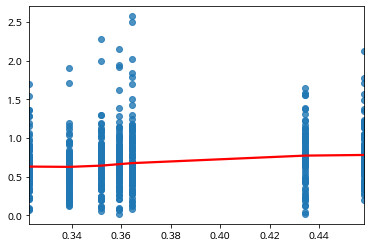

In [99]:
sns.regplot(
    x=ols_pred,
    y=np.sqrt(np.abs(sr)),
    lowess=True,
    line_kws={'color':'red'}    
)
plt.show()

**d. 모형의 선형성**

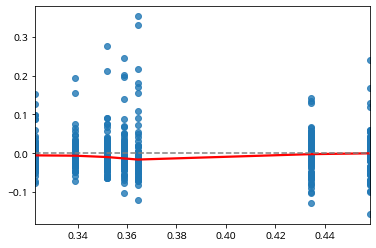

In [100]:
sns.regplot(
    x=ols_pred,
    y=residual,
    lowess=True,
    line_kws={'color':'red'}
)

plt.plot(
    [ols_pred.min(), ols_pred.max()],
    [0, 0],
    '--',
    color='grey'
)
plt.show()

**4) 가동률과 존 클릭 수 및 날씨(다중 회귀)**

**모형**

: 설명 변수로 존 클릭 수, 날씨, 그리고 요일을 넣어준다.

In [101]:
# 설명 변수 테이블 설정
_x_data = df_raws[['click_d_1', 'click_d_2', 'click_d_3', 'click_d_4', 'click_d_5', 'click_d_6', 'click_d_7', 'is_clean', 'avg_precipitation', 'avg_temperature']]

_x_weekday = pd.get_dummies(df_raws['weekday'], prefix='weekday', drop_first=False)

_x_data = pd.concat([_x_data, _x_weekday], axis=1)

# 예측 대상 데이터 설정
target = df_raws['op_rate_0d_all_cars']

# 상수항 추가
x_data = sm.add_constant(_x_data, has_constant='add')

# OLS 선형회귀 검정
model = sm.OLS(target, x_data)
model_fit = model.fit()

# 결과물 출력
print(model_fit.summary())

                             OLS Regression Results                            
Dep. Variable:     op_rate_0d_all_cars   R-squared:                       0.775
Model:                             OLS   Adj. R-squared:                  0.769
Method:                  Least Squares   F-statistic:                     130.3
Date:                 Wed, 16 Mar 2022   Prob (F-statistic):          6.39e-184
Time:                         06:00:56   Log-Likelihood:                 1228.1
No. Observations:                  623   AIC:                            -2422.
Df Residuals:                      606   BIC:                            -2347.
Df Model:                           16                                         
Covariance Type:             nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.2074

: R^2값이 단순 선형 회귀 분석을 할 때보다 높으므로 가동률을 더 잘 예측한다고 볼 수 있다.


**가설 검증**

In [102]:
# 가설 검증 재료
ols_pred = model_fit.fittedvalues

residual = model_fit.resid

**a. 잔차의 독립성**

: OLS 회귀 결과에 따르면 DW 값은 1.050이므로 잔차는 **양의 자기 상관**을 가진다고 판단할 수 있다

**b. 잔차의 정규성**

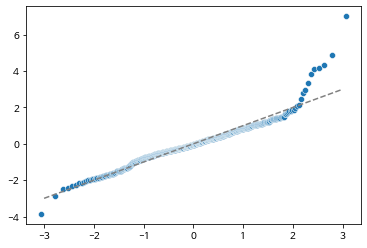

In [103]:
sr = scipy.stats.zscore(residual)

(x, y), _ = scipy.stats.probplot(sr)

sns.scatterplot(x=x, y=y)
plt.plot(
    [-3, 3],
    [-3, 3],
    '--',
    color='grey'
)
plt.show()

In [104]:
# 잔차의 정규성 검정: shapiro 검정
# 귀무가설: 잔차의 정규성이 만족한다
result = scipy.stats.shapiro(residual)
print( f'# 검정 통계량: {result[0]: .5f}')
print( f'# 유의 수준:  {result[1]: .5f}')

# 검정 통계량:  0.93349
# 유의 수준:   0.00000


: 유의 수준 5%를 가정할 경우, p = 0.0000이므로 **유의 수준 5%에서 잔차의 정규성을 만족한다는 귀무가설을 기각**할 수 있다.

**c. 잔차의 등분산성**

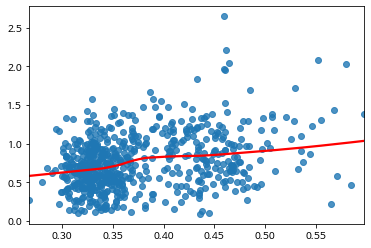

In [105]:
sns.regplot(
    x=ols_pred,
    y=np.sqrt(np.abs(sr)),
    lowess=True,
    line_kws={'color':'red'}    
)
plt.show()

**d. 모형의 선형성**

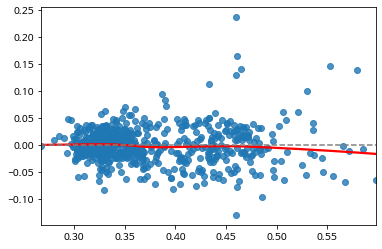

In [106]:
sns.regplot(
    x=ols_pred,
    y=residual,
    lowess=True,
    line_kws={'color':'red'}
)

plt.plot(
    [ols_pred.min(), ols_pred.max()],
    [0, 0],
    '--',
    color='grey'
)
plt.show()

: 결과를 정리하자면, 다중 회귀 검정(가동률과 존 클릭 수 및 날씨)이 가동률을 가장 예측을 잘 했다. 하지만 가정 검증에서 가정을 만족하지 않는 경우가 존재함. 즉 4가지 가정을 만족하지 못하므로 선형 회귀 모형이 잘 예측한다고 할 수는 없다. 이런 경우 WLS(Weighted Least Squares), GLS(Generalized Least Squares) 등의 방법을 적용할 수 있지만, 이번 프로젝트에서는 더 예측을 잘 할 수 있는 다른 모형을 사용하고자 한다.

### 회고.

: 먼저 결측치를 처리하고 데이터 타입을 맞춤으로써 데이터의 일관성을 확인하고, EDA를 통해 데이터의 기본 분포를 살펴보았다. 존 클릭 수 데이터로부터는 회원의 대부분이 이용 당일에 차량을 예약하는 패턴이 있음을, 사전 가동률 분포 데이터에서는 연휴기간, 연말~연초, 휴가철 등에 가동률이 증가함을 알 수 있었다.

상관관계 분석에서는 가동률과 존 클릭 수, 가동률과 날씨, 가동률과 요일의 관계가 어떻게 나타나는지 보았다. D-day로 갈수록 가동률과 존 클릭 수는 점점 강한 양의 상관관계를 보였다. 반면 가동률과 날씨는 상관관계가 잘 보이지 않지만 비가 오면 가동률이 더 높아지고, 매우 춥거나 더우면 가동률이 높지 않은 것을 알 수 있었다. 가동률과 요일에서는 평일과 주말의 차이가 크게 보이지 않았지만, 주말이 가동률과 조금 더 높은 양의 상관관계를 보인다는 것을 알 수 있었다.

선형 회귀 분석에서는 가동률과 존 클릭 수, 가동률과 날씨, 가동률과 요일을 단순 선형 회귀 분석하였고, 가동률과 존 클릭 수 및 날씬를 다룬 다중 회귀 분석까지 해 보았다. 각각의 경우 모형을 살펴본 후, 가정 검증을 했었다. 단순 선형 회귀 분석에서는 날씨나 요이로다 존 클릭 수가 가동률을 잘 설명했었다. 그러나 1개의 ㅕㄴ수보다 여러 개의 변수를 고려했을 때, 가동률이 가장 잘 예측되었다.

하지만 상관관계 분석과 선형 회귀 분석의 결과로 차량의 수요를 완벽히 예측할 수는 없었다